In [1]:
import numpy as np
import matplotlib.pyplot as plt
import general_functions
import scipy.stats
from matplotlib.animation import FuncAnimation

# Setup

Look at a single company $j$. At each time step, the company first buys, then sells, then pays interest. 
Ideal transactions will be assumed, meaning:
- When buying from company $i$, $p_i > m_j$, allowing us to set $p_i = m_j$ because of $B=\min(p_i, m_j)$
- The company always sells the maximum amount i.e. $p_j$.

The *simple loan* is defined as:
$$ \Delta d_j^{simple} = p_i - m_j $$
The choice of $p_i$ is important. By assumption, it must be larger than $m_j$. It is then expected that $p_i$ should be larger than $p_j$. I choose $p_i$ stochastically as $p_i \sim \mathcal{U}(m_j, 5p_j)$. It seems that the upper limit does not change the form of the \$ graphs, only the values (e.g. $5p_j$ yields $10^{9}$ and $10p_j$ yields $10^{19}$), yet the bankruptcy probability is shifted to lower values of $\alpha/r$ for a lower value for the upper limit.

The *smart loan* is defined as:
$$ \Delta d_j^{smart} = \max(\beta p_j  - rd_j, 0) $$
The max only serves to prevent negative values. The parameter $\beta$ is a measure of pessimism. $p_j - rd_j$ assumes the company sells once per update, and $\beta <1$ then takes the probability to not sell into account. A lower $\beta$ value drastically reduces the probability of bankruptcy, but also reduces the \$ values.
A reasonable value for $\beta$ is:
\begin{align}
    \beta &= 1 - P(\text{sell 0 times in an update}) \\
    &\approx 0.634
\end{align}

### Parameters

In [2]:
steps = 30

### Simulation - Smart loan

In [3]:
def smart_loan(p, d, m, r):
    beta = 0.634
    beta = 1
    return np.maximum(beta * p - r * d, 0)


def simple_loan(p, d, m, r):
    p_seller = np.random.uniform(m, 5 * p)
    return np.maximum(p_seller - m, 0)


def simulation(alpha, r, loan_size_func):
    # Initial values
    m = 1
    p = 1
    d = 0
    
    # Store values over time
    m_hist = []
    p_hist = []
    d_hist = []

    went_bankrupt = False

    for _ in range(steps):    
        # Buy. First take loan, find bought amount, update values
        loan_size = loan_size_func(p, d, m, r) 
        d += loan_size
        m += loan_size    

        B = m  # Because p_i > m_j by assumption.
        p += alpha * B 
        m = 0  # Uses money to buy
        
        # Sell
        m += p
        
        # Interest payment
        m -= r * d
        
        if m + p < r * d:
            went_bankrupt = True
        
        # Store values
        m_hist.append(1 * m)
        p_hist.append(1 * p)
        d_hist.append(1 * d)

    print("Went bankrupt:", went_bankrupt)
    return p_hist, d_hist, m_hist, went_bankrupt
    

In [4]:
def plot_value_bankruptcy(simulation_func, alpha, r, loan_size_func, ):
    p_hist, d_hist, m_hist, _ = simulation_func(alpha, r, loan_size_func, )
    
    p_hist = np.array(p_hist)
    d_hist = np.array(d_hist)
    m_hist = np.array(m_hist)
    
    # Plot        
    fig, (ax, ax1, ax2) = plt.subplots(nrows=3)
    # Values
    ax.plot(p_hist, label="p")
    ax.plot(d_hist, label="d")
    ax.plot(m_hist, label="m")
    ax.set(ylabel="log $", title=fr"{loan_size_func.__name__} $\alpha=${alpha}, $r=${r}", yscale="log")
    ax.legend()
    ax.grid()
        
    # p + m vs rd
    ax1.plot(p_hist + m_hist, label="Worth", alpha=0.7, color="green")
    ax1.plot(r * d_hist, label="Bankruptcy limit", alpha=0.7, color="orange", ls="dotted")
    ax1.set(ylabel="log $",yscale="log")
    ax1.legend()
    ax1.grid()
    
    # (p + m) / rd
    worth_over_debt = (p_hist + m_hist) / (r * d_hist)
    ax2.plot((p_hist + m_hist) / (r * d_hist), label=r"$(p+m)/(rd)$", color="darkblue")
    ax2.axhline(y=1, ls="dashed", alpha=0.7, color="grey", label="y=1")
    # ylim
    ymin = np.min(np.append(worth_over_debt, [1]))
    ymax = np.max(worth_over_debt)
    ylim = (ymin-0.5, 0.9 * ymax)
    ax2.set(xlabel="Time", ylabel="Worth / debt", ylim=ylim)
    # yticks - add the final value 
    convergence_value = np.mean(worth_over_debt[-10:]).round()
    current_locs = ax2.get_yticks()[1:]
    current_labels = ax2.get_yticklabels()[1:]
    new_locs = np.append(current_locs, convergence_value)
    new_labels = np.append(current_labels, convergence_value)
    sort_idx = np.argsort(new_locs)
    new_locs = new_locs[sort_idx]
    new_labels = new_labels[sort_idx]
    ax2.set_yticks(new_locs, new_labels)
    ax2.legend()
    ax2.grid()
    plt.show()

## Simulation - simple loan

Went bankrupt: False


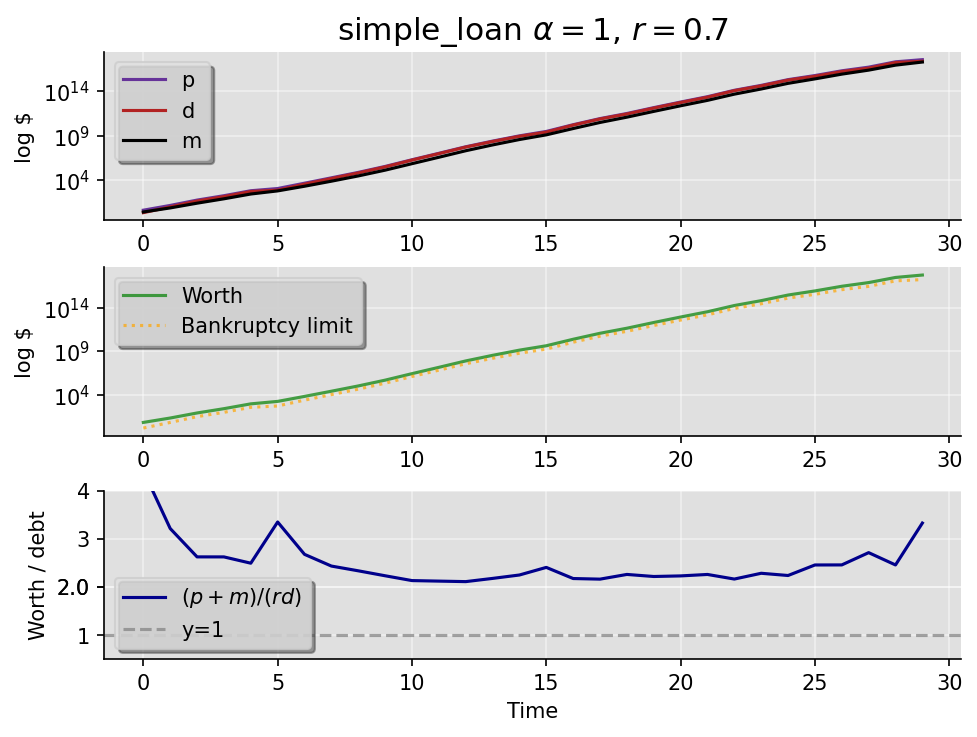

Went bankrupt: False


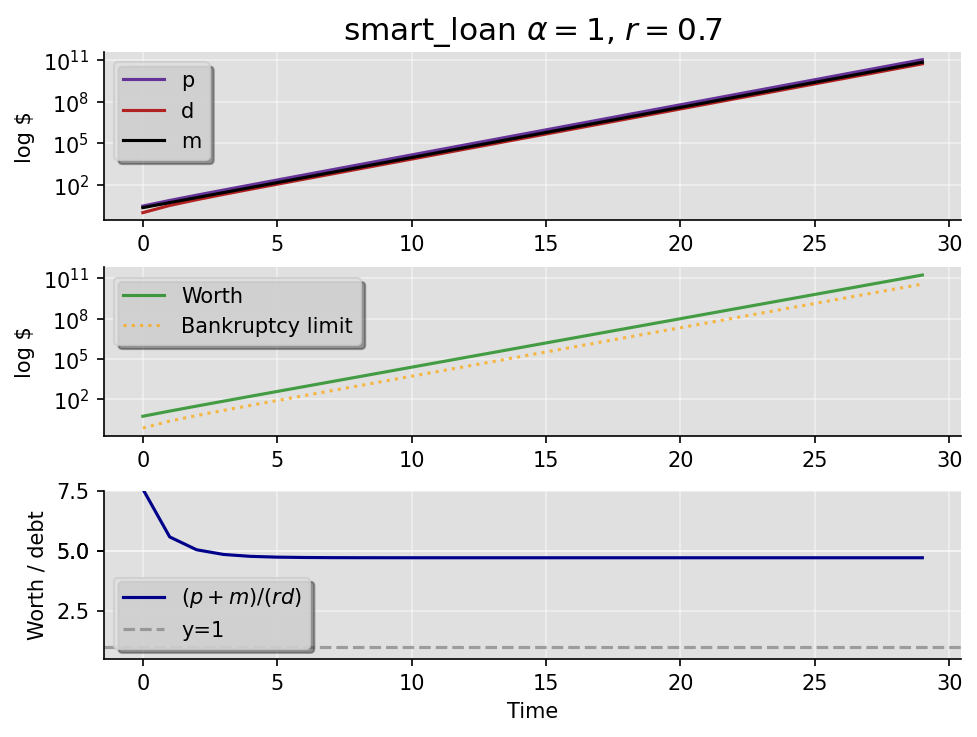

In [5]:
alpha = 1
r = 0.7
plot_value_bankruptcy(simulation, alpha, r, loan_size_func=simple_loan)
plot_value_bankruptcy(simulation, alpha, r, loan_size_func=smart_loan)

# Include chance to not sell or sell twice
Also find the probability to be chosen more than once.

In [6]:
N_company = 100
rv = scipy.stats.binom(n=N_company, p=1/N_company)

prob_two_instances = rv.pmf(k=2)
prob_zero_instances = rv.pmf(k=0)
prob_not_zero_but_two_instances = prob_two_instances / (1 - prob_zero_instances)
print("The probability to be chosen as seller ...")
print(f"\t 0 times = {prob_zero_instances:.4f}")
print(f"\t 2 times = {prob_two_instances:.4f}", )

The probability to be chosen as seller ...
	 0 times = 0.3660
	 2 times = 0.1849


In [7]:
prob_more_than_once = rv.sf(x=1)
print(f"The probability to be picked more than once per update as a seller is {prob_more_than_once:.4f}")

The probability to be picked more than once per update as a seller is 0.2642


In [8]:
def simulation_double_or_none(alpha, r, loan_size_func, ):
    # Initial values
    m = 1
    p = 1
    d = 0

    m_hist = []
    p_hist = []
    d_hist = []

    went_bankrupt = False

    # Probabilities to sell twice or none    
    for _ in range(steps):    
        # Buy. First take loan, find bought amount, update values
        loan_size = loan_size_func(p, d, m , r) 
        d += loan_size
        m += loan_size    

        B = np.maximum(m, 0)
        p += alpha * B 
        m = 0
        
        # Sell. 
        if np.random.uniform() < prob_zero_instances: 
            pass # No sell
        elif np.random.uniform() < prob_not_zero_but_two_instances:
            m += 2 * p  # Twice sell
        else:
            m += p  # One sell
        
        # Interest payment
        m -= r * d
        
        if m + p < r * d:
            went_bankrupt = True
        
        # Store values
        m_hist.append(1 * m)
        p_hist.append(1 * p)
        d_hist.append(1 * d)
    
    return p_hist, d_hist, m_hist, went_bankrupt

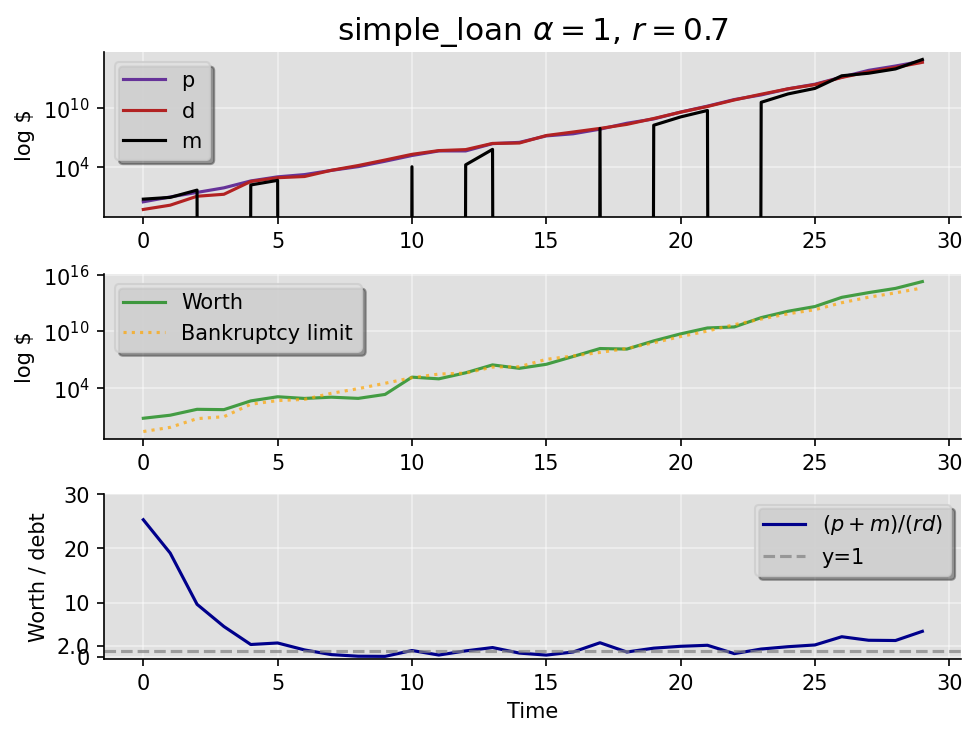

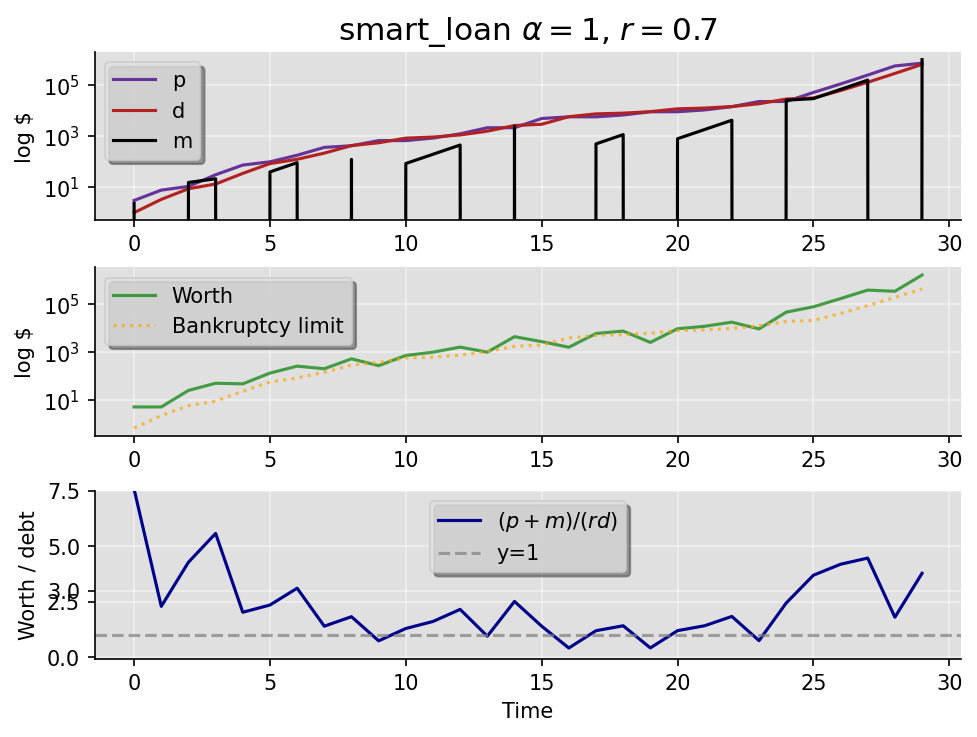

In [9]:
plot_value_bankruptcy(simulation_double_or_none, alpha, r, simple_loan, )
plot_value_bankruptcy(simulation_double_or_none, alpha, r, smart_loan, )

## plot bankruptices vs alpha / r

In [10]:
def bankruptcy_vs_alpha_r(N_repeats, alpha_vals, r_vals, parameter):    
    if parameter == "alpha":
        N_simple = np.empty((len(alpha_vals), N_repeats))
        N_smart = np.empty((len(alpha_vals), N_repeats))
        for i in range(N_repeats):
            for j, alpha in enumerate(alpha_vals):
                _, _, _, went_bankrupt_simple = simulation_double_or_none(alpha=alpha, r=r_vals, loan_size_func=simple_loan)
                _, _, _, went_bankrupt_smart = simulation_double_or_none(alpha=alpha, r=r_vals, loan_size_func=smart_loan)
                
                N_simple[j, i] = went_bankrupt_simple
                N_smart[j, i] = went_bankrupt_smart
    
    if parameter == "r":
        N_simple = np.empty((len(r_vals), N_repeats))
        N_smart = np.empty((len(r_vals), N_repeats))
        for k in range(N_repeats):
            for l, r in enumerate(r_vals):
                _, _, _, went_bankrupt_simple = simulation_double_or_none(alpha=alpha_vals, r=r, loan_size_func=simple_loan)
                _, _, _, went_bankrupt_smart = simulation_double_or_none(alpha=alpha_vals, r=r, loan_size_func=smart_loan)
                
                N_simple[l, k] = went_bankrupt_simple
                N_smart[l, k] = went_bankrupt_smart
    
    
    mean_simple = np.mean(N_simple, axis=1)
    mean_smart = np.mean(N_smart, axis=1)
    std_simple = np.std(N_simple, axis=1, ddof=1)
    std_smart = np.std(N_smart, axis=1, ddof=1)
    
    return mean_simple, mean_smart, std_simple, std_smart


def plot_bankruptcy_probability(N_repeats, alpha_vals, r_vals, parameter="alpha"):
    # Title
    if parameter == "alpha":
        title = fr"$r = ${r_vals}"
    else:
        title = fr"$\alpha = $ {alpha_vals}"    
        
    mean_simple, mean_smart, std_simple, std_smart = bankruptcy_vs_alpha_r(N_repeats, alpha_vals, r_vals, parameter)
    fig, ax = plt.subplots()
    ax.errorbar(alpha_vals/r_vals, mean_simple, yerr=std_simple, fmt=".-", label="Simple", alpha=1, elinewidth=1.2)
    ax.errorbar(alpha_vals/r_vals, mean_smart, yerr=std_smart, fmt=".--", label="Smart", alpha=0.8, elinewidth=1)
    ax.set(xlabel=r"$\alpha$/r", ylabel=f"Probability of bankruptcy over {steps} updates", title=title)
    ax.legend()
    ax.grid()
    path = "image/bankruptcy_probability/"
    plt.savefig(path + "bankruptcy_probability.png")
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'image/bankruptcy_probability/bankruptcy_probability.png'

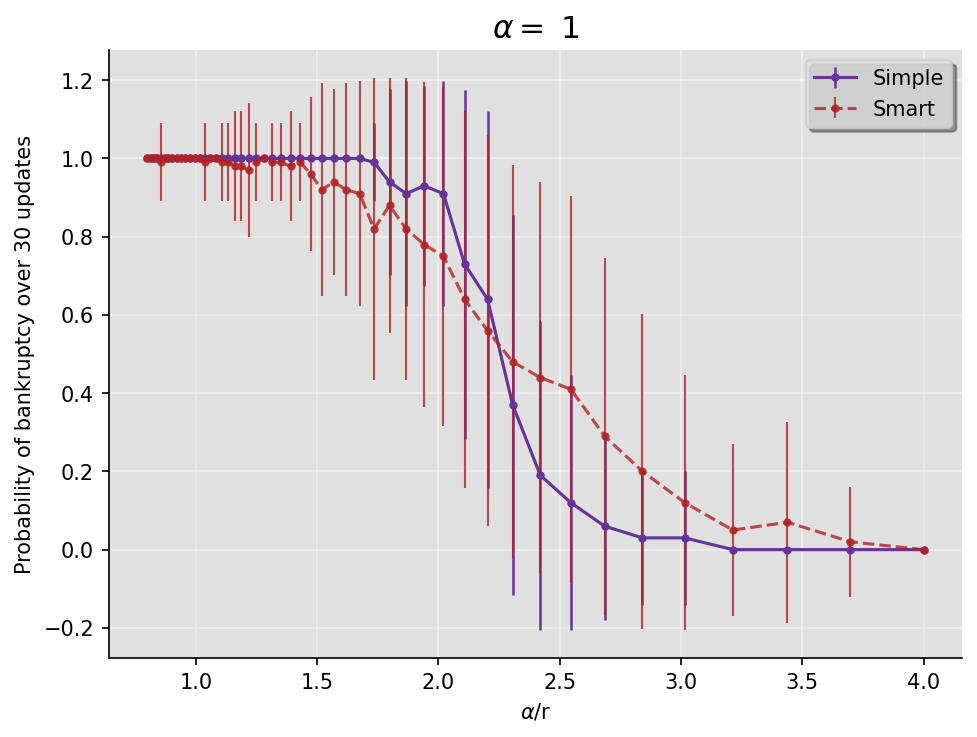

In [11]:
parameter = "r"

if parameter == "alpha":
    r_vals = 0.7
    alpha_over_r_vals = np.concatenate((np.linspace(0.001, 0.8, 20), 
                                        np.linspace(0.81, 1.5, 5), 
                                        np.linspace(1.55, 2.3, 20)))
    alpha_vals = r_vals * alpha_over_r_vals
    # alpha_vals = np.linspace(0.01, 0.25, 40)
else:
    alpha_vals = 1
    r_vals = np.linspace(0.25, 1.25, 50)


plot_bankruptcy_probability(N_repeats=100, alpha_vals=alpha_vals, r_vals=r_vals, parameter=parameter)

In [50]:
def animate_bankruptcy_probability(N_repeats, N_alpha_vals, r_vals):
    # Generate data
    mean_simple_arr = np.empty((len(r_vals), N_alpha_vals))
    mean_smart_arr = np.empty_like(mean_simple_arr)
    std_simple_arr = np.empty_like(mean_simple_arr)
    std_smart_arr = np.empty_like(mean_simple_arr)
    
    for i, r in enumerate(r_vals):
        alpha_vals = np.linspace(0.1 * r, 5 * r, N_alpha_vals)
        mean_simple, mean_smart, std_simple, std_smart = bankruptcy_vs_alpha_r(N_repeats, alpha_vals, r)
        mean_simple_arr[i] = mean_simple
        mean_smart_arr[i] = mean_smart
        std_simple_arr[i] = std_simple
        std_smart_arr[i] = std_smart
    
    # Animate
    fig, ax = plt.subplots()
    
    # Initial image
    ax.errorbar(alpha_vals/r, mean_simple_arr[0], yerr=std_simple_arr[0], fmt=".-", label="Simple", c="rebeccapurple", alpha=0.8, elinewidth=1)
    ax.errorbar(alpha_vals/r, mean_smart_arr[0], yerr=std_smart_arr[0], fmt=".--", label="Smart", c="firebrick", alpha=0.8, elinewidth=1)

    # Frame function
    def animate(i):
        # Clear current axis to get rid of previous graphs (highly inefficient yet here we are)
        plt.cla()
        # Graphs
        ax.errorbar(alpha_vals/r, mean_simple_arr[i], yerr=std_simple_arr[i], fmt=".-", c="rebeccapurple", alpha=0.8, elinewidth=1, label="Simple")
        ax.errorbar(alpha_vals/r, mean_smart_arr[i], yerr=std_smart_arr[i], fmt=".--", c="firebrick", alpha=0.8, elinewidth=1, label="Smart")
        # Axis setup
        ax.set(xlabel=r"$\alpha$/r", ylabel=f"Probability of bankruptcy over {steps} updates", title=fr"$r$ = {r_vals[i]}", ylim=(0, 1.2))
        ax.legend(loc="lower center", bbox_to_anchor=(0.5, 0.9), ncols=2)
        ax.grid()
        
    # Run animation
    anim = FuncAnimation(fig, animate, frames=len(r_vals), interval=1)
    # Save animation
    anim.save("image/bankruptcy_probability/bankruptcy_probability.mp4", fps=0.5)
    plt.close()

In [51]:
animate_bankruptcy_probability(N_repeats=75, N_alpha_vals=50, r_vals=[0.01, 0.05, 0.1, 0.2, 0.25, 0.5, 1])

# Debt-production system

In [20]:
def p_and_d(steps, alpha, beta, r):
    p = 1
    d = 0
    
    p_list = np.empty(steps)
    d_list = np.empty(steps)
    p_list[0] = p * 1
    d_list[0] = d * 1
    
    for i in range(steps):
        # Sell
        B = alpha * (beta * p / r - d)
        p += alpha * B
        d += B
        
        # Interest 
        d += r * d
        
        p_list[i] = p * 1
        d_list[i] = d * 1
    
    return p_list, d_list

In [21]:
def plot_p_and_d(steps, alpha, beta, r):
    p_list, d_list = p_and_d(steps, alpha, beta, r)
    
    # p_list = p_list[-10:]
    # d_list = d_list[-10:]
    
    fig, ax = plt.subplots()
    ax.plot(p_list, label=r"$p$")
    ax.plot(r * d_list, label=r"$rd$")
    ax.set(xlabel="Time", ylabel="log $", title=fr"$\alpha=${alpha}, $\beta=${beta}, $r=${r}")
    ax.legend()
    ax.grid()
    plt.show()

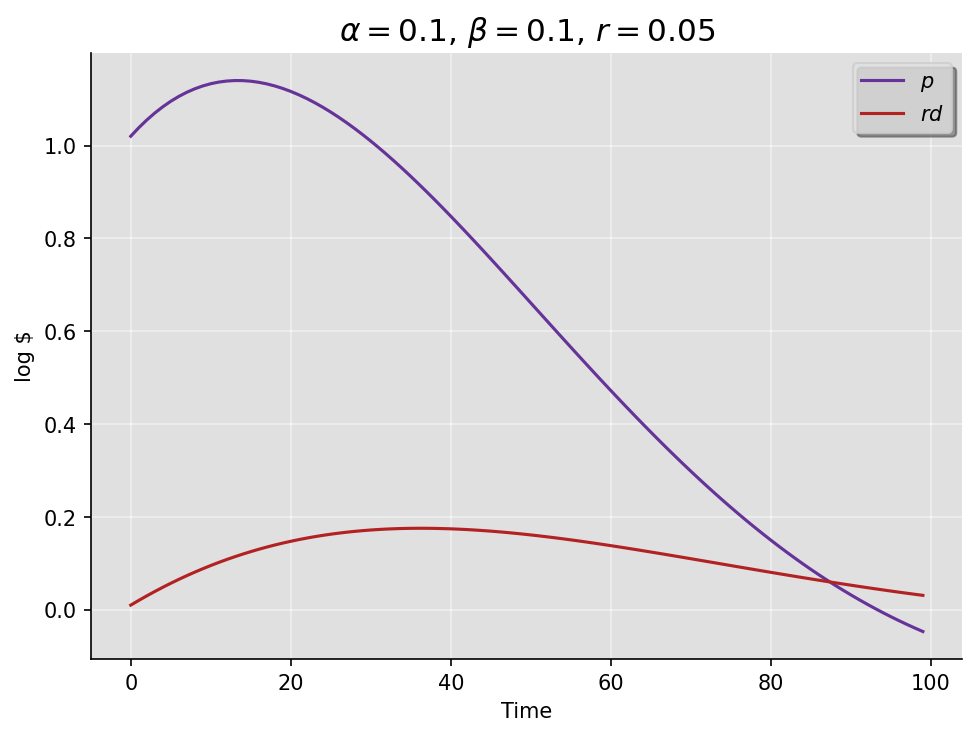

In [115]:
plot_p_and_d(steps=100, alpha=0.1, beta=0.1, r=0.05)

In [12]:
def rd_larger_than_p(p, d, r):
    """Time to bankruptcy when rd > p. If rd is never larger than p, return the max time.
    """
    time_steps = np.arange(p.size)
    time_larger = time_steps[-1]  # In case rd is never larger than d, pick the max time as the time
    
    points_larger = np.where(p < r * d)[0]
    
    if points_larger.size != 0:
        time_larger = points_larger[0]
        
    return time_larger


def d_larger_than_p(p, d, r):
    time_steps = np.arange(p.size)
    time_larger = time_steps[-1]  # In case rd is never larger than d, pick the max time as the time
    
    points_larger = np.where(p < d)[0]
    
    if points_larger.size != 0:
        time_larger = points_larger[0]
        
    return time_larger
    

In [13]:
def plot_bankruptcy_time(func_p_and_d, func_T, steps, alpha_vals, beta_vals, r_vals, parameter_idx=(3, 6, 5)):
    parameter_idx_ab, parameter_idx_ar, parameter_idx_br = parameter_idx
    
    # Get data
    T_arr = np.ones((alpha_vals.size, beta_vals.size, r_vals.size)) * -1  # -1 to know that a value has not been calculated
    for i, a in enumerate(alpha_vals):
        for j, b in enumerate(beta_vals):
            for k, r in enumerate(r_vals):
                p, d = func_p_and_d(steps, a, b, r)
                T_arr[i, j, k] = func_T(p, d, r)
    

    # Make contour plots of alpha vs beta, alpha vs r, beta vs r
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(15, 5))
    vmin = 0
    vmax = steps
    cbar_ticks = np.linspace(vmin, vmax, 6)
    cmap = "magma"    
    # alpha vs beta
    
    im0 = ax0.contourf(alpha_vals, beta_vals, T_arr[:, :, parameter_idx_ab], levels=20, vmin=vmin, vmax=vmax, cmap=cmap)
    ax0.set(xlabel=r"$\alpha$", ylabel=r"$\beta$", title=fr"$r = {r_vals[parameter_idx_ab]:.2f}$")
    fig.colorbar(im0, ticks=cbar_ticks, label="Time to bankruptcy")

    # alpha vs r
    im1 = ax1.contourf(alpha_vals, r_vals, T_arr[:, parameter_idx_ar, :], levels=20, vmin=vmin, vmax=vmax, cmap=cmap)
    ax1.set(xlabel=r"$\alpha$", ylabel=r"$r$", title=fr"$\beta = {beta_vals[parameter_idx_ar]:.2f}$")
    fig.colorbar(im1, ticks=cbar_ticks, label="Time to bankruptcy")
    
    # beta vs r
    im2 = ax2.contourf(beta_vals, r_vals, T_arr[parameter_idx_br, :, :], levels=20, vmin=vmin, vmax=vmax, cmap=cmap)
    ax2.set(xlabel=r"$\beta$", ylabel=r"$r$", title=fr"$\alpha = {alpha_vals[parameter_idx_br]:.2f}$")
    fig.colorbar(im2, ticks=cbar_ticks, label="Time to bankruptcy")

    fig.suptitle(f"Time to bankruptcy, steps = {steps}")

    plt.show()

In [14]:
steps = 30
alpha_vals = np.linspace(0.01, 0.4, 30)
beta_vals = np.linspace(1e-2, 1, 30)
r_vals = np.concatenate((np.linspace(0.01, 0.1, 5), np.linspace(0.11, 0.3, 25)))

print("p < rd")
plot_bankruptcy_time(p_and_d, rd_larger_than_p, steps, alpha_vals, beta_vals, r_vals)
print("p < d")
plot_bankruptcy_time(p_and_d, d_larger_than_p, steps, alpha_vals, beta_vals, r_vals)

p < rd


NameError: name 'p_and_d' is not defined

In [15]:
def p_and_d_selling(steps, alpha, beta, r):
    p = 1
    d = 0
    
    p_list = np.empty(steps)
    d_list = np.empty(steps)
    p_list[0] = p * 1
    d_list[0] = d * 1
    
    for i in range(steps):
        random_number = np.random.uniform()
        
        # buy then sell
        if random_number > 0:        
            B = (beta * p - r * d) / (r - alpha * beta)
            p += alpha * B
            d += r * (d - p + B)
        # Sell then buy
        else:
            d -= p
            p += (beta * p - r * d) / (r - alpha * beta)
            d += r * d
        
        p_list[i] = p * 1
        d_list[i] = d * 1
    
    return p_list, d_list

p < rd


C:\Users\tobia\AppData\Local\Temp\ipykernel_2532\2049856866.py:15: RuntimeWarning: overflow encountered in scalar multiply
  B = (beta / r * p - d)
C:\Users\tobia\AppData\Local\Temp\ipykernel_2532\2049856866.py:17: RuntimeWarning: invalid value encountered in scalar add
  d += r * (d - p + B)


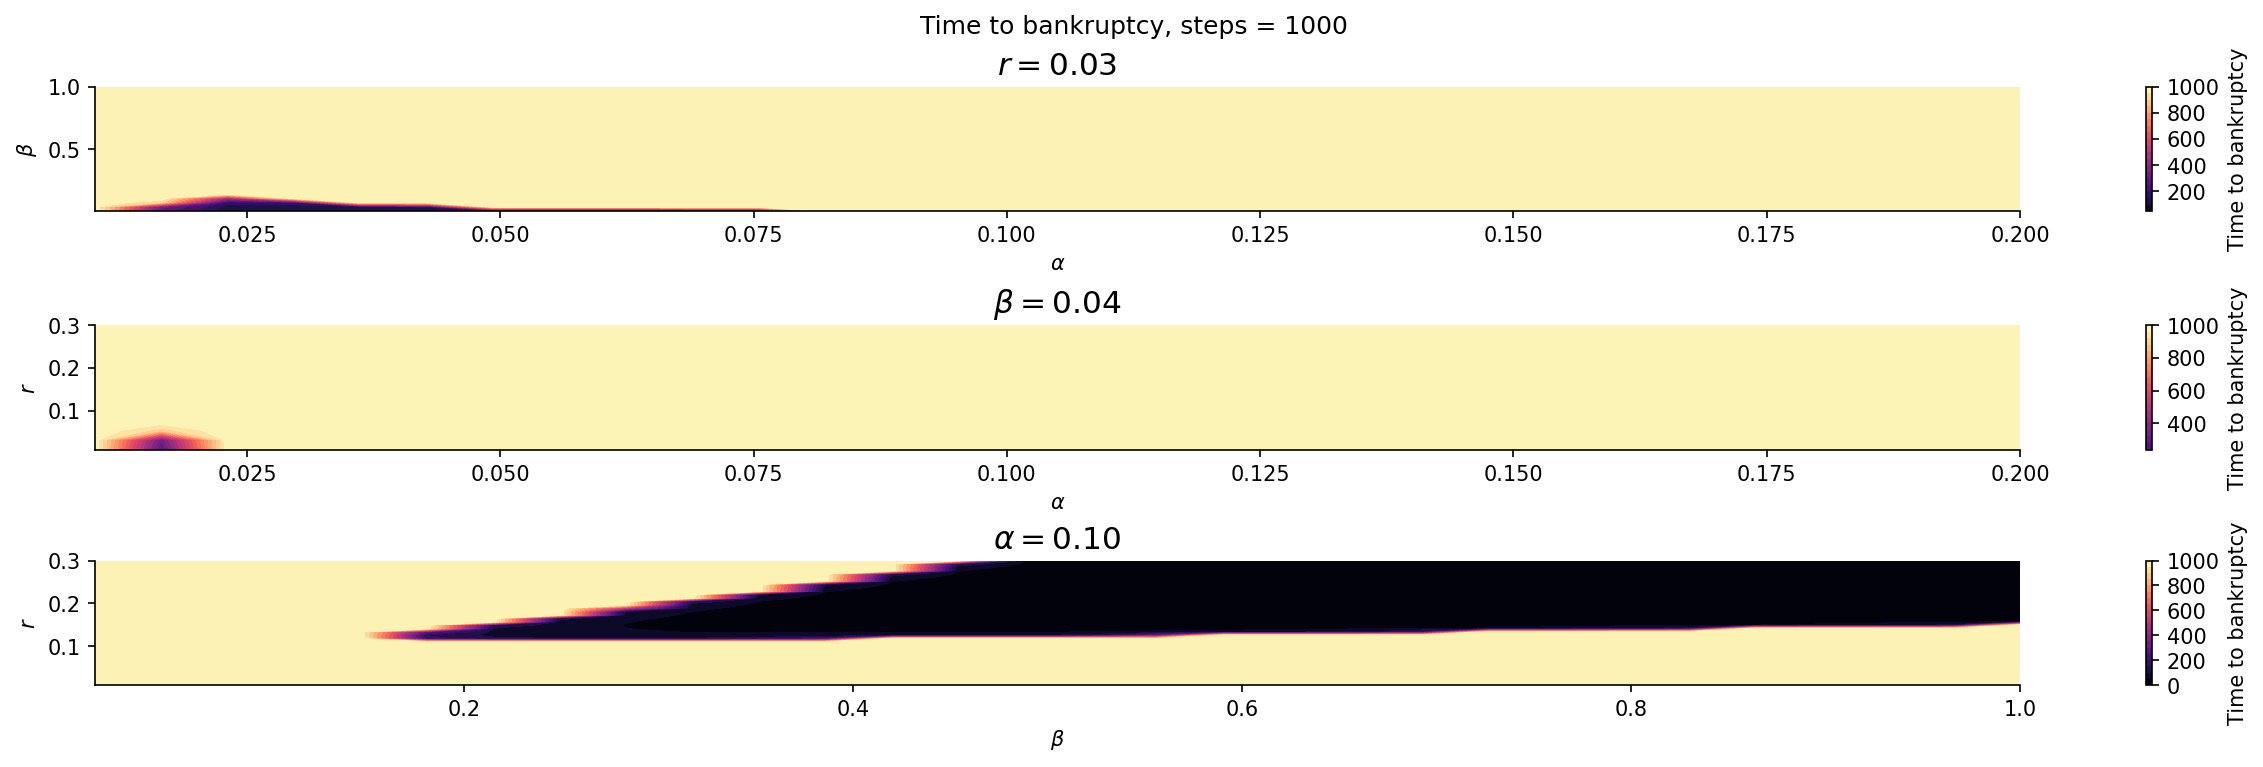

p < d


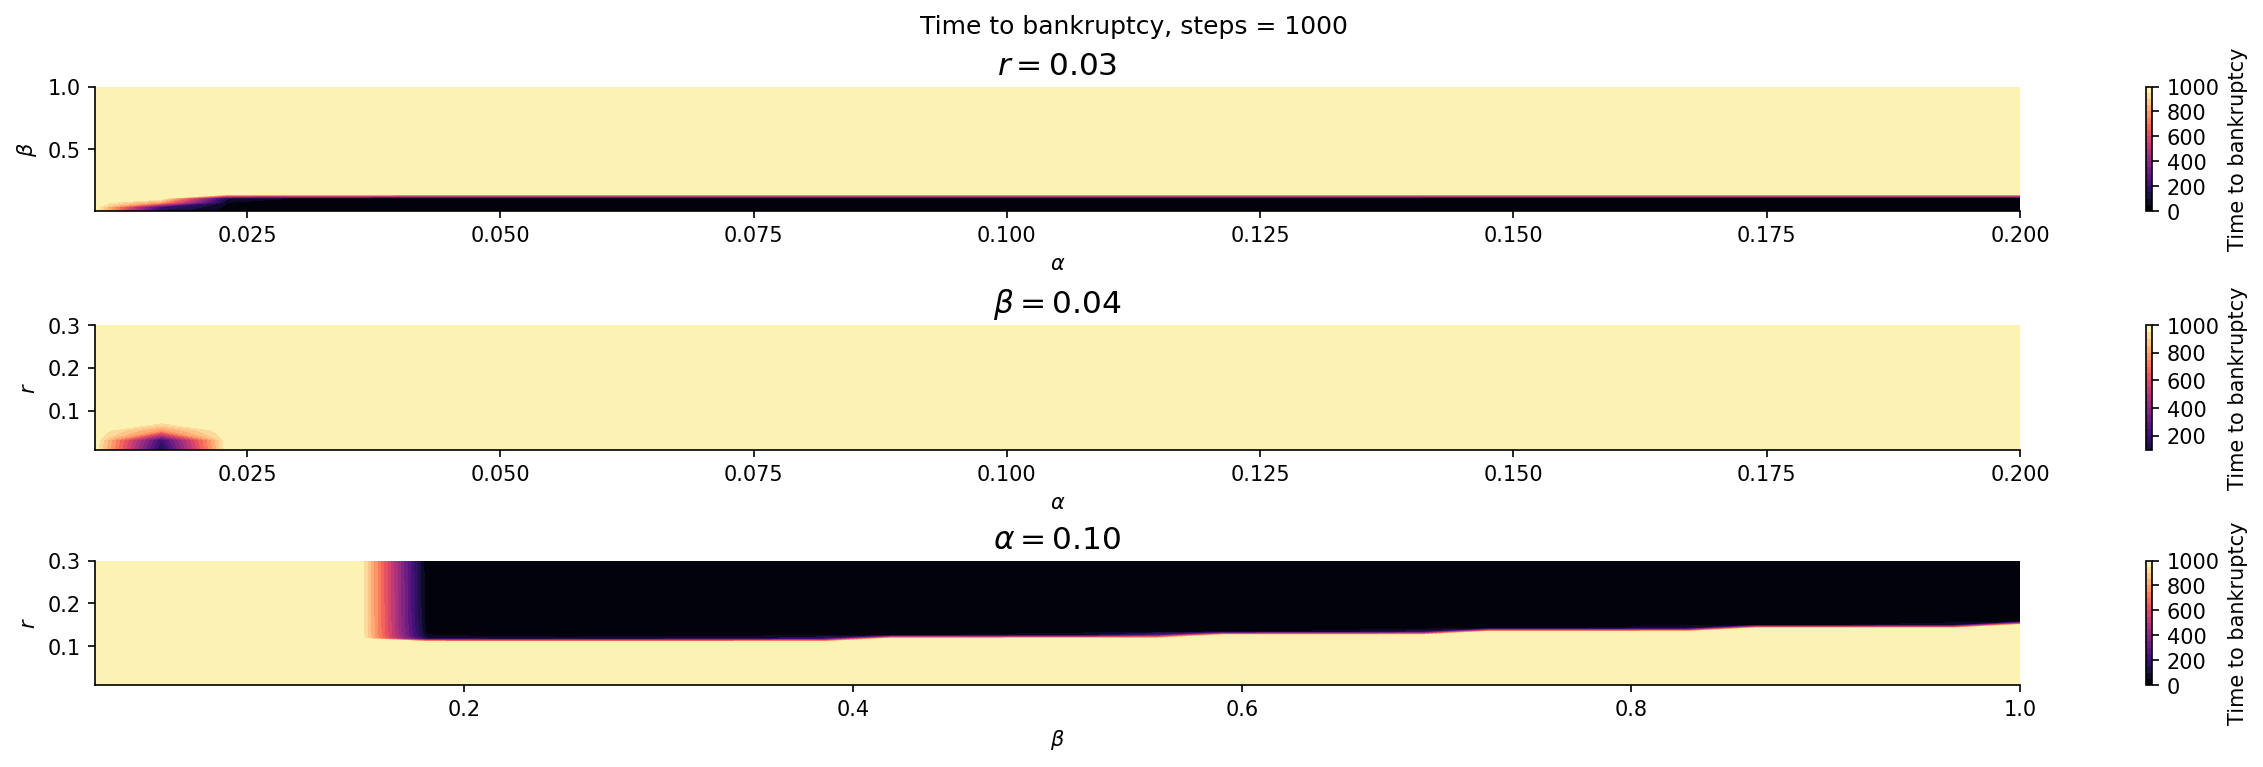

In [19]:
steps = 1000
alpha_vals = np.linspace(0.01, 0.2, 30)
beta_vals = np.linspace(1e-2, 1, 30)
r_vals = np.concatenate((np.linspace(0.01, 0.1, 5), np.linspace(0.11, 0.3, 25)))
parameter_idx = (1, 1, 13)

print("p < rd")
plot_bankruptcy_time(p_and_d_selling, rd_larger_than_p, steps, alpha_vals, beta_vals, r_vals, parameter_idx)
print("p < d")
plot_bankruptcy_time(p_and_d_selling, d_larger_than_p, steps, alpha_vals, beta_vals, r_vals, parameter_idx)

In [17]:
def plot_p_and_d_selling(steps, alpha, beta, r):
    p_list, d_list = p_and_d_selling(steps, alpha, beta, r)
    
    # p_list = p_list[-10:]
    # d_list = d_list[-10:]
    
    fig, ax = plt.subplots()
    ax.plot(p_list, label=r"$p$")
    ax.plot(r * d_list, label=r"$rd$")
    ax.plot(d_list, label=r"$d$")
    ax.set(xlabel="Time", ylabel="log $", title=fr"$\alpha=${alpha}, $\beta=${beta}, $r=${r}")
    ax.legend()
    ax.grid()
    plt.show()

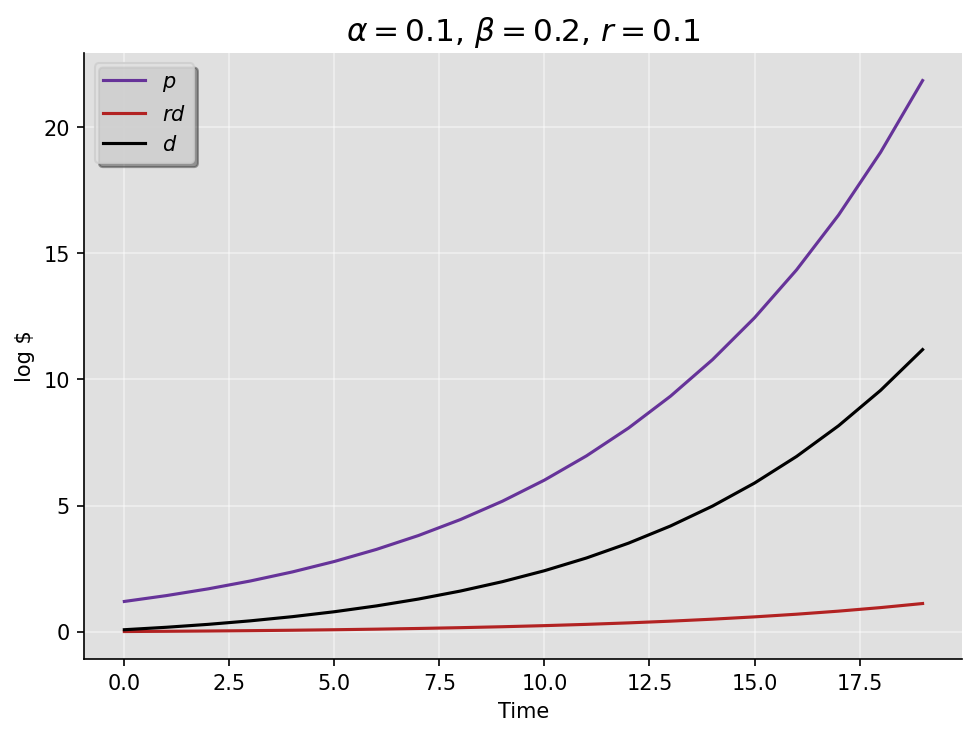

In [18]:
plot_p_and_d_selling(steps=20, alpha=0.1, beta=0.2, r=0.1)